## Carregamento dos Dados

In [14]:
import tensorflow as tf

x_train = tf.keras.utils.image_dataset_from_directory(
    "dataset/train",
    labels="inferred", # Os rótulos são definidos a partir dos nomes das subpastas
    label_mode="categorical", # Formato categórico dos rótulos
    batch_size=32, # Lotes de 32 imagens
    image_size=(128, 128), # Redimensiona as imagens para 128x128
    shuffle=True, # Embaralha as imagens para evitar que a rede aprenda padrões de ordenação
)

x_test = tf.keras.utils.image_dataset_from_directory(
    "dataset/test",
    labels="inferred", # Os rótulos são definidos a partir dos nomes das subpastas
    label_mode="categorical", # Formato categórico dos rótulos
    batch_size=32, # Lotes de 32 imagens
    image_size=(128, 128), # Redimensiona as imagens para 128x128
    shuffle=False, # Não precisa embaralhar nos dados de teste
)

x_val = tf.keras.utils.image_dataset_from_directory(
    "dataset/validation",
    labels="inferred", # Os rótulos são definidos a partir dos nomes das subpastas
    label_mode="categorical", # Formato categórico dos rótulos
    batch_size=32, # Lotes de 32 imagens
    image_size=(128, 128), # Redimensiona as imagens para 128x128
    shuffle=False, # Não precisa embaralhar nos dados de validação
)

Found 7000 files belonging to 7 classes.
Found 1400 files belonging to 7 classes.
Found 1400 files belonging to 7 classes.


## Normalização

In [15]:
# Camada que normaliza as imagens do intervalo [0, 255] para [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Aplicação a normalização às imagens de cada dataset
x_train = x_train.map(lambda x, y: (normalization_layer(x), y))
x_val = x_val.map(lambda x, y: (normalization_layer(x), y))
x_test = x_test.map(lambda x, y: (normalization_layer(x), y))

## Criação do Modelo CNN

Para a criação da CNN foi utilizado o modelo **Sequential**, o qual estabelece uma sequência de camadas que são empilhadas e executadas sequencialmente.

### Camada Convolucional

Essa camada detecta os padrões presentes na imagem e retorna as suas características.

Uma camada `Conv2D` usa filtros, uma pequena matriz de números, que desliza sobre a imagem. Em cada posição é realizado uma operação matemática que retorna um número que representa o quão presente é o padrão daquele filtro na imagem; quanto maior o número mais presente será esse padrão. No final dessa operação é retornado um mapa de características. Se tiver 32 filtros, haverá 32 mapas de características diferentes, cada um destacando um tipo específico de padrão.

Em cada mapa é aplicado a função de ativação `ReLU (max(0, z))`, que transforma todas os negativos em 0.

Na primeira camada Convolucional é aplicado **32 filtros** de matriz **3x3** à imagem original de **128x128**, resultando em **32 mapas de características**. Esses filtros aprenderão caracaterísticas de baixo nível, como bordas e cantos.

Os 32 mapas da camada anterior servirão como entrada para a segunda camada, onde **64 novos filtros** percorrerão esses mapas. Os filtros dessa camada irão combinar as características de baixo nível que foram aprendidas na camada anterior para detectar padrões mais complexos. Ao final dessa camada terá **64 novos mapas de características**.

A terceira camada Convolucional executará o mesmo processo anterior com **128 filtros**, resultando em **128 mapas de características** com padrões ainda mais complexos e abstratos.

### Camada de Pooling

Após cada camada Convolucional é executado uma camada de agrupamento, onde o tamanho dos mapas de características é reduzido. Neste caso, o `MaxPooling2D` divide os mapas em regiões **2x2** e seleciona o valor máximo dentro de cada região.

Ao realizar esse processo, o tamanho dos mapas é reduzido pela metade, mantendo apenas as características mais relevantes. Além disso, a diminuição de parâmetros ajuda a prevenir o overfitting.

### Camada de Flatten

Nessa camada a estrutura 3D das informações que foram passadas pelas camadas anteriores são transformadas em um único vetor 1D. Isso é necessário porque as próximas camadas esperam uma entrada em formato de vetor.

### Camada de Dropout

A técnica de `Dropout` utilizada nessa camada está "desligando" (define como 0) aleatoriamente 50% dos neurônios da camada anterior em cada iteração do treinamento. Isso é necessário porque força o modelo a aprender características mais robustas das imagens e não depender apenas de um único neurônio para tomar a decisão. Essa camada evita que o modelo aprenda demais de quaisquer características ajudando a generalizar melhor, evitando o overfitting.

### Camada Densa

As camadas densas são onde as características aprendidas são combinadas para a decisão final, em que os 128 neurônios realizam um cálculo ponderado de todos os valores de entrada do vetor da camada anterior.

$$Output_j = \sum_{i} (Input_i \times Weight_{ij}) + Bias_j$$

O resultado desse cálculo passa pela função de ativação **ReLU**. Se o valor for positivo, ele permanece o mesmo; se for negativo, torna-se zero.

Por fim, é executado a última camada do modelo, em que os 7 neurônios dessa camada, que correspondem às 7 classes das células, recebem a saída dos 128 neurônios da camada anterior e realizam novamente o cálculo ponderado.

As saídas desses 7 neurônios são passados pela função **Softmax**, que converte os valores em probabilidades, onde cada valor está entre **0 e 1**. A soma das probabilidades de todas as 7 saídas sempre será igual a 1. O neurônio com maior probabilidade indica classe que foi prevista pelo modelo.

In [16]:
# Modelo sequencial onde as camadas são empilhadas uma acima da outra
model = tf.keras.Sequential([
    
    # Primeira camada Convolucional 
    tf.keras.layers.Conv2D(32, # Número de filtros
                           (3, 3), # Tamanho do filtro (3 por 3 pixels)
                           activation='relu', # Função de ativação ReLU
                           input_shape=(128, 128, 3)), # Dimenções das imagens

    # Reduz a resolução da imagem pela metade através do agrupamento guloso de um grupo de 2 por 2 pixels
    tf.keras.layers.MaxPooling2D((2, 2)), 

    # Segunda camada Convolucional 
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Terceira camada Convolucional 
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Transforma a saída 3D da ultima camada em um vetor de uma dimenção
    tf.keras.layers.Flatten(),
    
    # Evita overfitting desligando 50% dos neurónios de maneira aleatória durante os treinos
    tf.keras.layers.Dropout(0.5),

    # Camada com 128 neurônios conectados
    tf.keras.layers.Dense(128, activation='relu'),
    
    # Camada com o numero de tipos de celulas e função de ativação Softmax (transforma valores em probabilidades)
    tf.keras.layers.Dense(7, activation='softmax')
])

## Compilação do Modelo

Aqui o modelo é configurado para treinamento. Durante a compilação são definidos três elementos essenciais:
- <strong>Otimizador</strong>: Algoritmo responsável por realizar ajustes nos pesos da rede neural a cada iteração durante o treinamento com base nos erros. O modelo escolhido foi o <strong>Adam</strong>, que ajusta dinamicamente a taxa de aprendizado e acelera a convergência.
- <strong>Função de perda</strong>: Indica o quão distante está a resposta do valor esperado. A função escolhida foi a categorical crossentropy, adequada para problemas com rótulos armazenados em formato de vetor onde a posição da classe correta fica em 1 enquanto as demais ficam em 0.
- <strong>Métrica de avaliação</strong>: Serve para acompanhar o desempenho do modelo durante o treinamento. Aqui foi usada a acurácia, que mede a proporcão entre a quantidade de acertos e de amostras. 

In [17]:
# Compila o modelo deixado pronto para treino
model.compile(
    # Otimizador 
    optimizer='adam',
    # Função de perda
    loss='categorical_crossentropy',
    # Métrica para acompanhar a acurácia. 
    metrics=['accuracy']
)

## Treinamento

O modelo é treinado usando o _model.fit_, que executa multiplas épocas sobre a base de dados. Cada época passa por um conjunto de validação para acompanhamento do progresso. 

In [18]:
history = model.fit(
    x_train, # Dados de treinamento
    validation_data=x_val, # Validação que acontece a cada época
    epochs=20  # pode ajustar conforme o desempenho
)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 97s 430ms/step - accuracy: 0.3215 - loss: 1.6640 - val_accuracy: 0.4593 - val_loss: 1.3639
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 90s 410ms/step - accuracy: 0.5142 - loss: 1.2709 - val_accuracy: 0.5357 - val_loss: 1.2284
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 90s 412ms/step - accuracy: 0.6050 - loss: 1.0634 - val_accuracy: 0.5836 - val_loss: 1.1471
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 98s 446ms/step - accuracy: 0.6770 - loss: 0.8600 - val_accuracy: 0.6221 - val_loss: 1.0966
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 97s 443ms/step - accuracy: 0.7528 - loss: 0.6673 - val_accuracy: 0.6079 - val_loss: 1.1814
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 97s 443ms/step - accuracy: 0.7961 - loss: 0.5505 - val_accuracy: 0.6450 - val_loss: 1.1793
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 97s 444ms/step - accuracy: 0.8468 - loss: 0.4086 - val_accuracy: 0.6629 - val_loss: 1.1952
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 97s 443ms/step - accuracy: 0.8841 - loss: 0

## Testes

Essa étapa faz uso do conjunto de dados de teste para julgar o quão bom foi o treinamento do modelo. Ele retorna as métricas definidas na compilação.

In [19]:
test_loss, test_accuracy = model.evaluate(x_test) # Avalia o conjunto de dados
print(f"Acurácia no conjunto de teste: {test_accuracy:.4f}") # Imprime a acurácia do treinamento


44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.6470 - loss: 2.0818
Acurácia no conjunto de teste: 0.6986


## Métricas

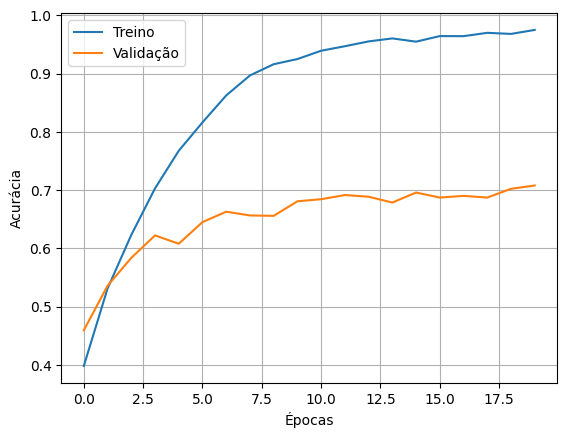

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel("Épocas") # épocas de treinamento
plt.ylabel("Acurácia") # proporção de previsões corretas
plt.legend()
plt.grid()

# Apresenta um gráfico de linha que acompanha a evolução do modelo ao longo do tempo.
plt.show()
